In [ ]:
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model

In [ ]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:]
y_train = y_train[:-2000]

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [ ]:
inp = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [ ]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [ ]:
model.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])

In [ ]:
# Record start time
start_time = time.time()
print('Training started at %s', time.ctime(start_time))


In [ ]:
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=20)

Epoch 1/40
907/907 [==============================] - 187s 161ms/step - loss: 1.0262 - dense_4_loss: 0.7414 - dense_1_loss: 0.4529 - dense_3_loss: 0.4967 - dense_4_accuracy: 0.7410 - dense_1_accuracy: 0.8448 - dense_3_accuracy: 0.8292 - val_loss: 0.1834 - val_dense_4_loss: 0.1421 - val_dense_1_loss: 0.0625 - val_dense_3_loss: 0.0751 - val_dense_4_accuracy: 0.9555 - val_dense_1_accuracy: 0.9845 - val_dense_3_accuracy: 0.9750
Epoch 2/40
907/907 [==============================] - 143s 158ms/step - loss: 0.2031 - dense_4_loss: 0.1438 - dense_1_loss: 0.0956 - dense_3_loss: 0.1021 - dense_4_accuracy: 0.9567 - dense_1_accuracy: 0.9711 - dense_3_accuracy: 0.9681 - val_loss: 0.1197 - val_dense_4_loss: 0.0897 - val_dense_1_loss: 0.0468 - val_dense_3_loss: 0.0533 - val_dense_4_accuracy: 0.9725 - val_dense_1_accuracy: 0.9910 - val_dense_3_accuracy: 0.9820
Epoch 3/40
907/907 [==============================] - 143s 158ms/step - loss: 0.1314 - dense_4_loss: 0.0900 - dense_1_loss: 0.0666 - dense_3_los

In [ ]:

# Record end time
end_time = time.time()
print('Training ended at %s', time.ctime(end_time))

# Calculate duration of training
duration = end_time - start_time
print('Training duration: %i seconds', int(duration))

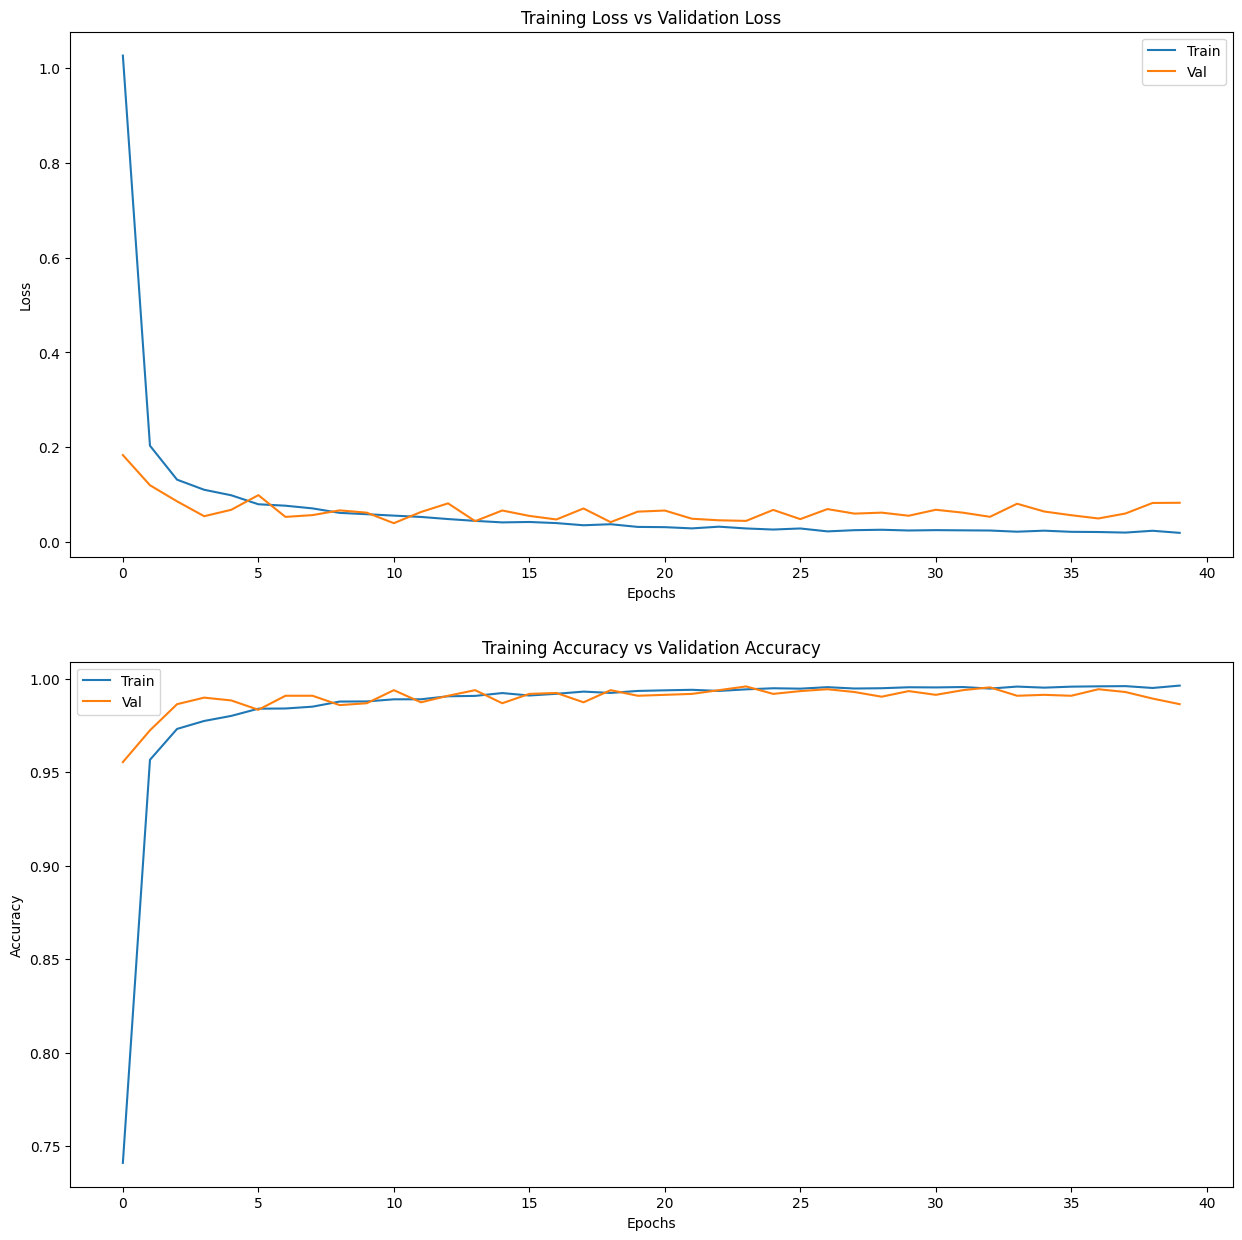

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 10s 27ms/step - loss: 0.0763 - dense_4_loss: 0.0502 - dense_1_loss: 0.0464 - dense_3_loss: 0.0406 - dense_4_accuracy: 0.9880 - dense_1_accuracy: 0.9913 - dense_3_accuracy: 0.9926


[0.0762762650847435,
 0.05017838254570961,
 0.04639967903494835,
 0.04059328883886337,
 0.9879999756813049,
 0.9912999868392944,
 0.9926000237464905]